# Part B: Invasion Percolation

The next percolation algorithm to be demonstrated is known as ``Invasion Percolation``. Instead of identifying connected clusters and invading them all in one go, as ``Ordinary Percolation`` does, this algorithm progresses one invasion step at a time. This is a more dynamic process and better simulates scenarios where instead of controlling the pressure at the network boundaries something else such as mass flow rate is controlled as the pressure is allowed to fluctuate up and down in order to meet the lowest available entry pressure for the growing cluster(s).

In [1]:
import sys
import openpnm as op
%config InlineBackend.figure_formats = ['svg']
import numpy as np
np.random.seed(10)
import matplotlib.pyplot as plt
import porespy as ps
from ipywidgets import interact, IntSlider
from openpnm.topotools import trim
%matplotlib inline
ws = op.Workspace()
ws.settings["loglevel"] = 40

In order to also showcase some other network generation options we first start with a small 2D network with ``StickAndBall`` geometry.

In [2]:
spacing=2.5e-5
net = op.network.Cubic([20, 20, 1], spacing=spacing)
geo = op.geometry.StickAndBall(network=net, pores=net.Ps, throats=net.Ts)

We then trim all the surface pores to obtain disctint sets of boundary edge pores.

In [3]:
net.labels()
net.num_throats('surface')
trim(network=net, throats=net.throats('surface'))
h = net.check_network_health()
trim(network=net, pores=h['trim_pores'])

Then we use a function from our porespy package to generate a tomography style image of the abstract network providing the number of pixels in each dimension.

In [4]:
# NBVAL_IGNORE_OUTPUT
im = ps.io.openpnm_to_im(net, max_dim=1000)


--------------------------------------------
| Generating voxel image from pore network |
--------------------------------------------


Generating throats: 100%|██████████| 684/684 [00:00<00:00, 3204.16it/s]


In [5]:
im.shape

(1000, 1000, 50)

This creates a 3D image but we can crop it to get the central slice in 2D for visualization.

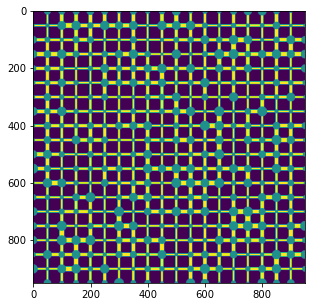

In [6]:
# NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots(figsize=(5, 5))
plt.imshow(im[25:-25, 25:-25, 25].T)
crop = im[25:-25, 25:-25, :]

Next the snow algorithm is used to do network extraction on the tomography style image. Of course if you have your own tomogrpahy image this can be used instead.

In [7]:
# NBVAL_IGNORE_OUTPUT
snow_out = ps.networks.snow(crop > 0, voxel_size=4e-7)

------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  1080
Peaks after trimming saddle points:  381
Peaks after trimming nearby peaks:  381
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 453/453 [00:05<00:00, 83.43it/s]


In [8]:
snow_out.regions.shape

(956, 956, 56)

The SNOW algorithm provides a labelled region image containing the pore index. As zero is used for the background it is actually the pore index + 1 because python references arrays with first element as zero and we do not explicitly store the pore index.

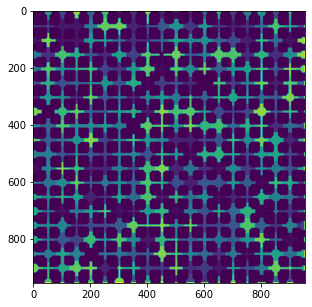

In [9]:
# NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots(figsize=(5, 5))
reg = snow_out.regions.astype(float) - 1
reg[reg == -1] = np.nan
region_slice = snow_out.regions[:, :, 28] - 1
mask = region_slice >= 0
plt.imshow(region_slice.T);

Now our new network is extracted we can fill a network object with all the properties and begin simulation.

In [10]:
wrk = op.Workspace()
wrk.clear()

In [11]:
net = op.network.GenericNetwork()
net.update(snow_out)
geo = op.geometry.GenericGeometry(network=net, pores=net.Ps, throats=net.Ts)

A helper function is defined for plotting a particular data set.

In [12]:
def update_image(data):
    data = data.astype(float)
    out_im = np.ones(region_slice.shape, dtype=float)*-1
    out_im[mask] = data[region_slice[mask]]
    out_im[~mask] = np.nan
    return out_im

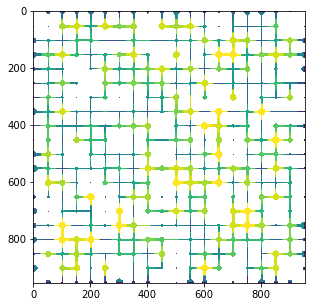

In [13]:
# NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots(figsize=(5, 5))
out = update_image(net['pore.diameter'])
plt.imshow(out.T);

Again, stadard physics is used to define the capillary entry pressures. And these are shown as a histogram for all the throats in the network.

In [14]:
water = op.phases.Water(network=net)
phys = op.physics.Standard(network=net, geometry=geo, phase=water)

(array([ 30.,  13.,  34.,  50., 115., 121.,   5., 151.,   0., 222.]),
 array([ 7229.81209008, 10400.20383214, 13570.5955742 , 16740.98731626,
        19911.37905832, 23081.77080038, 26252.16254244, 29422.5542845 ,
        32592.94602657, 35763.33776863, 38933.72951069]),
 <a list of 10 Patch objects>)

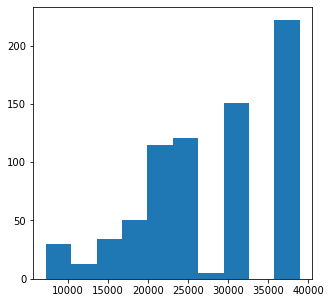

In [15]:
# NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots(figsize=[5, 5])
ax.hist(phys['throat.entry_pressure'], bins=10)

Next, the algorithm is defined and run with no arguments or outlets defined. This will proceed step by step assessing which pores are currently invaded (i.e. inlets first), which throats connect to an uninvaded pore and of these, which throat has the lowest capillary entry pressure for invasion. Invasion then proceeds along the path of least capillary resistance.

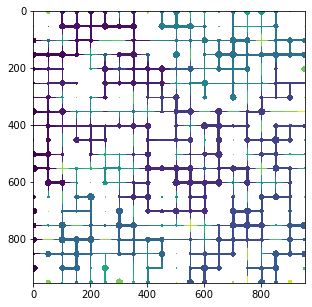

In [16]:
# NBVAL_IGNORE_OUTPUT
alg_ip = op.algorithms.InvasionPercolation(network=net)
alg_ip.setup(phase=water)
alg_ip.set_inlets(pores=net.pores('left'))
alg_ip.run()
fig, ax = plt.subplots(figsize=(5, 5))
out = update_image(alg_ip['pore.invasion_sequence'])
plt.imshow(out.T);

In [17]:
def plot_invasion(seq):
    data = alg_ip['pore.invasion_sequence'] < seq
    fig, ax = plt.subplots(figsize=(5, 5))
    out = update_image(data)
    plt.imshow(out.T);

Using the slider below we can interactively plot the saturation at each invasion step (this works best using the left and right arrow keys).

In [18]:
# NBVAL_IGNORE_OUTPUT
max_seq = alg_ip['pore.invasion_sequence'].max()
interact(plot_invasion, seq=IntSlider(min=0, max=max_seq, step=1, value=200))

interactive(children=(IntSlider(value=200, description='seq', max=734), Output()), _dom_classes=('widget-inter…

<function __main__.plot_invasion(seq)>

As with ``Ordinary Percolation`` we can plot a drainage or intrusion curve but this time the capillary pressure is plotted from one step to the next as a continuous process with dynamic pressure boundary conditions and so is allowed to increase and decrease to meet the next lowest entry pressure for the invading cluster.

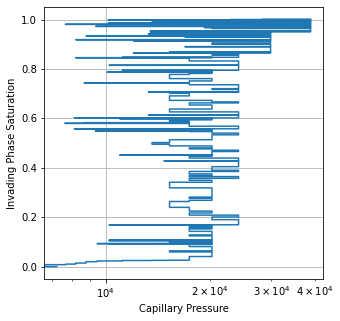

In [19]:
# NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots(figsize=(5, 5))
alg_ip.plot_intrusion_curve(fig)
plt.show()

We can compare the results of the two algorithms and see that the pressure envelope, i.e. maximum pressure reached historically by the invasion process is the same as the ordinary percolation value.

------------------------------------------------------------
SOURCE     : openpnm.algorithms.OrdinaryPercolation.get_intrusion_data 
TIME STAMP : 2020-10-07 09:45:10,469
------------------------------------------------------------


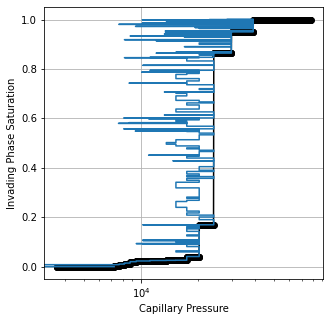

In [20]:
# NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots(figsize=(5, 5))
alg_op = op.algorithms.OrdinaryPercolation(network=net, phase=water)
alg_op.set_inlets(net.pores('left'))
alg_op.setup(pore_volume='pore.volume',
             throat_volume='throat.volume')
alg_op.run(points=1000)
alg_op.plot_intrusion_curve(fig)
alg_ip.plot_intrusion_curve(fig)
plt.show()

An additional feature of the algorithm is the ability to identify where the defending phase becomes trapped. Whether this happens in reality in-fact relies on the connectivity of the defending phase and whether it can reside in the invaded pores as thin wetting films. If not then the defending phase is completely pushed out of a pore when invaded and it can become isolated and trapped when encircled by the invading phase. OpenPNM actually calculates this trapping as a post-process, employing some clever logic described by [Masson 2016](http://dx.doi.org/10.1016/j.cageo.2016.02.003).

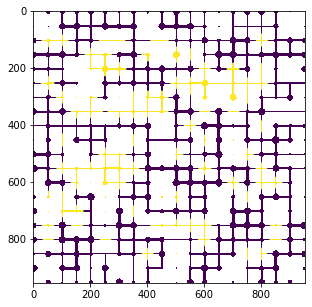

In [21]:
# NBVAL_IGNORE_OUTPUT
alg_ip_t = op.algorithms.InvasionPercolation(network=net)
alg_ip_t.setup(phase=water)
alg_ip_t.set_inlets(pores=net.pores('left'))
alg_ip_t.run()
alg_ip_t.apply_trapping(outlets=net.pores(['boundary']))
fig, ax = plt.subplots(figsize=(5, 5))
out = update_image(alg_ip_t['pore.trapped'])
plt.imshow(out.T);

Here a reasonable fraction of the pore space is not invaded due to trapping of the defending phase. Generally this fraction will be lower in truly 3D networks as there are more routes out of the network because pores have higher connectivity. Also, typically if a defending phase is considered to be wetting then film flow is assumed to allow residual defending phase to escape. However, we can show the differences on one plot with and without trapping below.

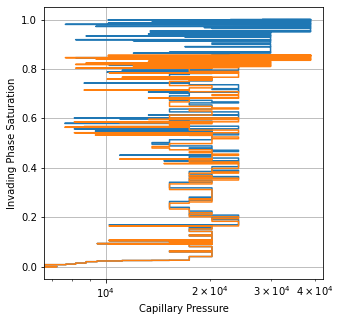

In [22]:
# NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots(figsize=(5, 5))
alg_ip.plot_intrusion_curve(fig)
alg_ip_t.plot_intrusion_curve(fig)
plt.show()